# Spot Parameter Inference using Gradient Descent

This notebook demonstrates how to use JAX's automatic differentiation to compute gradients with respect to stellar surface spot parameters and optimize them using gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax import random
import optax

# Import SPICE modules
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spot
from spice.spectrum import simulate_observed_flux
from transformer_payne import TransformerPayne
from tqdm import tqdm


## 1. Create a "ground truth" spotted star model

First, we'll create a reference star with spots that will serve as our "ground truth" for the inference process.

In [2]:
from spice.models.utils import velocity_to_period, inclination_to_los_axis

# Set a random seed for reproducibility
key = random.PRNGKey(42)

true_rotation_velocity = 25.
true_inclination = 15.
wavelengths = jnp.linspace(6060, 6070., 200)

rotation_phases = jnp.linspace(0, velocity_to_period(true_rotation_velocity, 1.), 10)

true_temp = 6000.
true_logg = 4.5

true_spot_theta = jnp.pi/2.
true_spot_phi = jnp.pi/4.
true_spot_radius = jnp.deg2rad(30.)
true_fe_diff = 1.5 

tp = TransformerPayne.download()
m = IcosphereModel.construct(500, 1., 1., tp.to_parameters(dict(logteff=jnp.log10(true_temp), logg=true_logg)),
                                                                 tp.stellar_parameter_names)

true_spot = add_spot(m,
                     spot_center_theta=true_spot_theta,
                     spot_center_phi=true_spot_phi,
                     spot_radius=jnp.rad2deg(true_spot_radius),
                     parameter_delta=true_fe_diff,
                     parameter_index=27)

# Add the spot to the surface - assuming parameter_index 0 corresponds to temperature
true_rotation = add_rotation(true_spot, true_rotation_velocity, inclination_to_los_axis(true_inclination))
true_rotation_ev = [evaluate_rotation(true_rotation, t) for t in rotation_phases]

In [3]:
def evaluate_rotated_spectrum(model, time):
    spec = simulate_observed_flux(tp.intensity, evaluate_rotation(model, time), jnp.log10(wavelengths), distance=0.1)
    return spec[:, 0]/spec[:, 1]

evaluate_rotated_spectra = jax.vmap(evaluate_rotated_spectrum, in_axes=(None, 0))
spectra = evaluate_rotated_spectra(true_rotation, rotation_phases)

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/linear_util.py:370: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in logspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  ans = _fun(*args, **kwargs)
/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


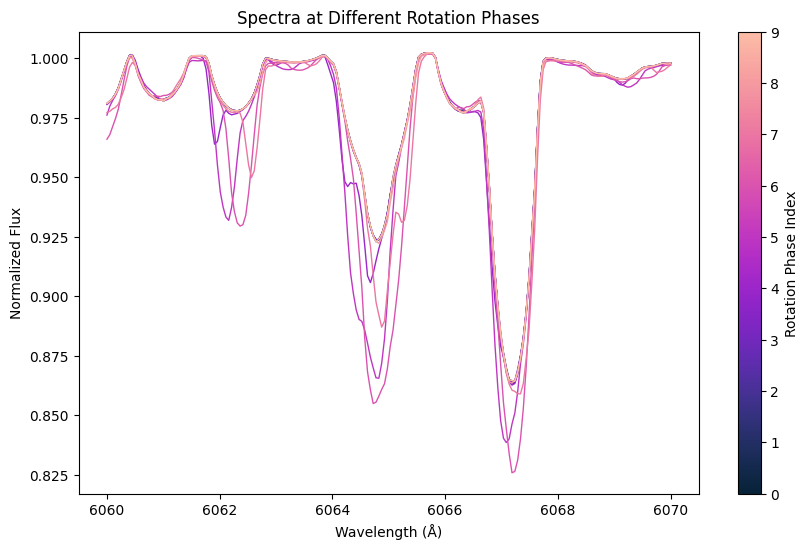

In [4]:
import matplotlib
%matplotlib inline

import cmasher as cmr
# Create a colormap to represent different phases
cmap = cmr.bubblegum
norm = plt.Normalize(vmin=0, vmax=len(spectra)-1)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(spectra):
    color = cmap(norm(i))
    phase = rotation_phases[i]
    ax.plot(wavelengths, s, color=color, zorder=1, linewidth=1)  # Label every 10th phase for clarity

# Add a colorbar to show the phase progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the ax argument
cbar.set_label('Rotation Phase Index')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Spectra at Different Rotation Phases')
plt.show()

## 2. Generate "observed" data

To simulate the inference process, we'll generate synthetic observations by rotating the star and computing the integrated spectrum or flux at each rotation phase.

In [5]:
# Function to compute the integrated flux for a given mesh at a specific rotation phase
def __spherical_to_cartesian(theta: float, phi: float, radius: float):
    x = jnp.sin(theta) * jnp.cos(phi) * radius
    y = jnp.sin(theta) * jnp.sin(phi) * radius
    z = jnp.cos(theta) * radius
    return x, y, z


def __cartesian_distance(x1: float, y1: float, z1: float, x2: float, y2: float, z2: float):
    return jnp.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)


v_cartesian_distance = jax.jit(jax.vmap(__cartesian_distance, in_axes=(0, 0, 0, None, None, None)))


def create_surface(mesh, spot_params):
    spot_center_theta, spot_center_phi, spot_radius, delta = spot_params

    spot_center_x, spot_center_y, spot_center_z = __spherical_to_cartesian(spot_center_theta, spot_center_phi,
                                                                           mesh.radius)

    # Calculate distance from the spot center
    distances = v_cartesian_distance(mesh.d_centers[:, 0], mesh.d_centers[:, 1], mesh.d_centers[:, 2],
                                     spot_center_x, spot_center_y, spot_center_z)

    # Calculate the difference from the spot edge
    distance_from_edge = spot_radius * mesh.radius - distances

    # Apply smoothness to interpolate values at the spot's edge
    # Use a small fraction of mesh radius for scaling, but ensure it's not too small
    scale_factor = jnp.maximum(0.01 * mesh.radius, 1e-6)
    
    # Prevent NaN by clipping extremely negative values before the sigmoid
    # This prevents exp(-large_negative) from overflowing
    safe_distance = jnp.clip(distance_from_edge/scale_factor, -50.0, 50.0)
    
    # Use sigmoid function to create a smooth transition at the spot edge
    spot_mask = 1.0 / (1.0 + jnp.exp(-safe_distance))
    
    # Check for NaN values in the mask and replace with zeros
    spot_mask = jnp.nan_to_num(spot_mask, nan=0.0)
    
    # Apply the spot effect using the smooth mask
    differences = spot_mask * delta
    
    # Update the parameter at index 27 (likely temperature or another physical property)
    mesh = mesh._replace(parameters=mesh.parameters.at[:, 27].set(mesh.parameters[:, 27] + differences))
    return add_rotation(mesh, true_rotation_velocity, inclination_to_los_axis(true_inclination))

def compute_rotated_spectrum(spot_params):
    return evaluate_rotated_spectra(create_surface(m, spot_params), rotation_phases)

# Generate the "observed" light curve data
observed_fluxes = compute_rotated_spectrum((true_spot_theta, true_spot_phi, true_spot_radius, true_fe_diff))

# Add some random noise to simulate real observations
noise_level = 0.001 * jnp.max(observed_fluxes)  # 0.1% noise
key, subkey = random.split(key)
noise = random.normal(subkey, shape=observed_fluxes.shape) * noise_level
observed_fluxes_with_noise = observed_fluxes + noise

In [6]:
sm = create_surface(m, (0, 0., jnp.deg2rad(30.), true_fe_diff))

In [7]:
r1 = compute_rotated_spectrum((0, 0., jnp.deg2rad(30.), true_fe_diff))

In [8]:
r1.shape, observed_fluxes_with_noise.shape

((10, 200), (10, 200))

In [9]:
abs_errors = jnp.abs(r1 - observed_fluxes_with_noise)
    # Find the 0.95 quantile threshold
threshold = jnp.quantile(abs_errors, 0.95)
    
# Filter errors exceeding the threshold
high_errors = jnp.where(abs_errors >= threshold, abs_errors, 0.)

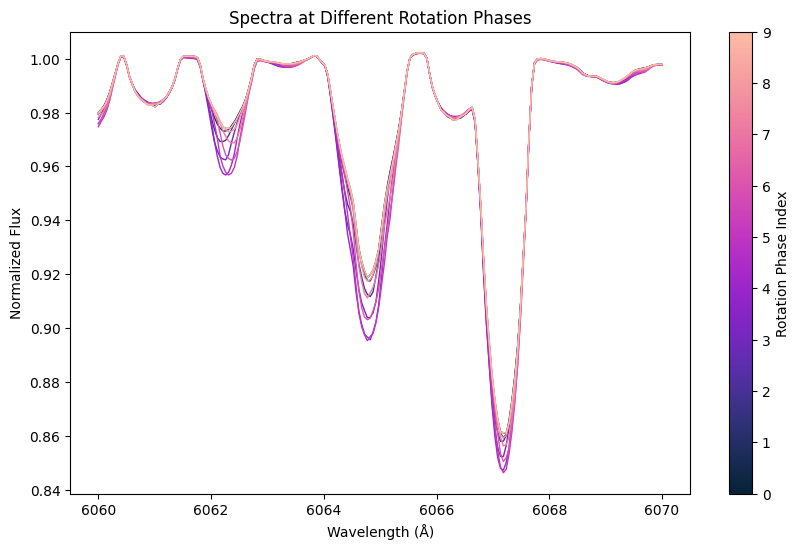

In [10]:
cmap = cmr.bubblegum
norm = plt.Normalize(vmin=0, vmax=len(spectra)-1)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(r1):
    color = cmap(norm(i))
    phase = rotation_phases[i]
    ax.plot(wavelengths, s, color=color, zorder=1, linewidth=1)  # Label every 10th phase for clarity

# Add a colorbar to show the phase progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the ax argument
cbar.set_label('Rotation Phase Index')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Spectra at Different Rotation Phases')
plt.show()

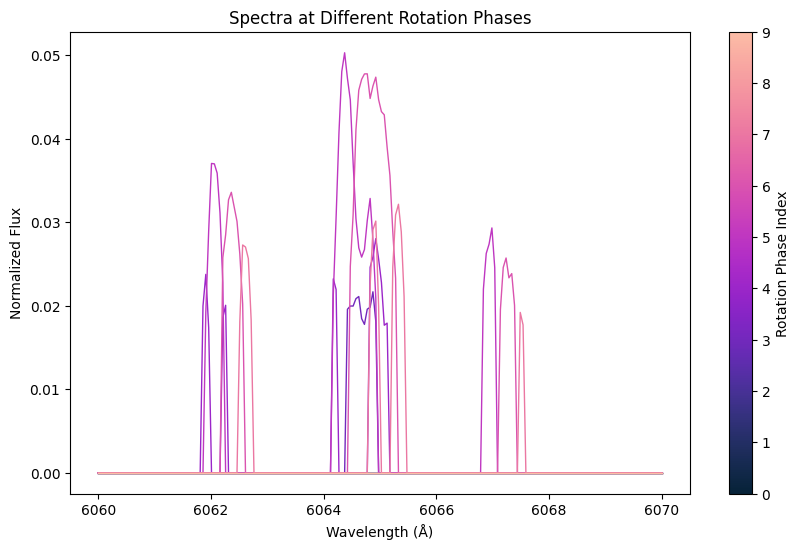

In [11]:
cmap = cmr.bubblegum
norm = plt.Normalize(vmin=0, vmax=len(spectra)-1)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(high_errors):
    color = cmap(norm(i))
    phase = rotation_phases[i]
    ax.plot(wavelengths, s, color=color, zorder=1, linewidth=1)  # Label every 10th phase for clarity

# Add a colorbar to show the phase progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the ax argument
cbar.set_label('Rotation Phase Index')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Spectra at Different Rotation Phases')
plt.show()

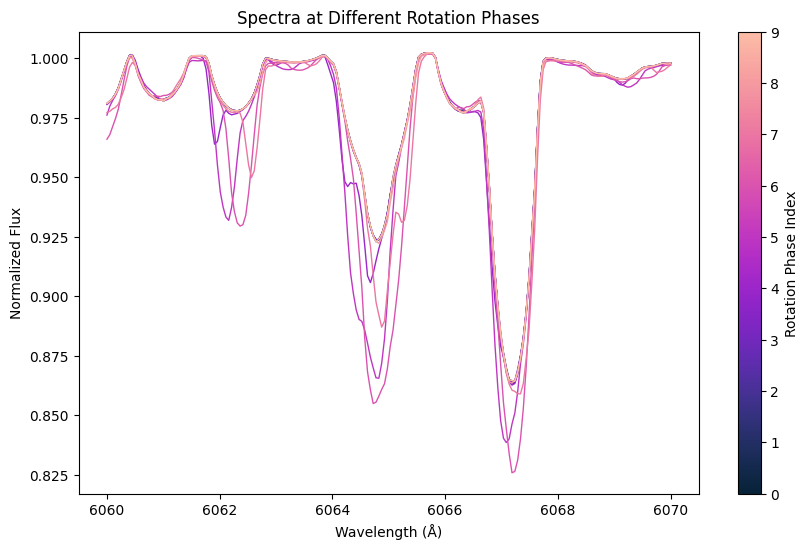

In [12]:
cmap = cmr.bubblegum
norm = plt.Normalize(vmin=0, vmax=len(spectra)-1)

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

for i, s in enumerate(spectra):
    color = cmap(norm(i))
    phase = rotation_phases[i]
    ax.plot(wavelengths, s, color=color, zorder=1, linewidth=1)  # Label every 10th phase for clarity

# Add a colorbar to show the phase progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)  # Explicitly provide the ax argument
cbar.set_label('Rotation Phase Index')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Normalized Flux')
ax.set_title('Spectra at Different Rotation Phases')
plt.show()

## 3. Set up the parameter inference problem

Now we'll create a model with initial guess parameters and use JAX's automatic differentiation to compute gradients with respect to the spot parameters.

In [13]:
# Define the loss function (mean squared error between model and observed fluxes)
def loss_fn(spot_params):
    # Compute the model light curve for the current parameters
    model_fluxes = compute_rotated_spectrum(spot_params)
    # Calculate mean of errors exceeding the threshold
    mse = jnp.mean(jnp.abs(model_fluxes - observed_fluxes_with_noise))
    
    return mse

loss_and_grad_fn = jax.jit(value_and_grad(loss_fn))

In [ ]:
# Create a grid of parameters to evaluate the loss function
# Define parameter ranges
from spice.models.utils import lat_to_theta, lon_to_phi, theta_to_lat, phi_to_lon

theta_range = lat_to_theta(jnp.linspace(-90, 90, 10))  # Inclination from 0 to π
phi_range = lon_to_phi(jnp.linspace(-180, 180, 10))  # Azimuth from -π to π
radius_range = jnp.deg2rad(jnp.linspace(5, 60, 10))  # Spot radius in degrees
fe_diff_range = jnp.array([true_fe_diff])  # Using the true Fe difference

# Create meshgrid for visualization
theta_grid, phi_grid = jnp.meshgrid(theta_range, phi_range)
loss_grid = jnp.zeros((len(phi_range), len(theta_range), len(radius_range)))

# Evaluate loss function over the grid
from tqdm import tqdm

with tqdm(total=len(radius_range)*len(phi_range)*len(theta_range)) as pbar:
    for i, radius in enumerate(tqdm(radius_range)):
        for j, phi in enumerate(phi_range):
            for k, theta in enumerate(theta_range):
                params = (theta, phi, radius, true_fe_diff)
                loss_grid = loss_grid.at[j, k, i].set(loss_fn(params))
                pbar.update(1)
# Find the minimum loss and corresponding parameters
min_idx = jnp.argmin(loss_grid)
min_idx_3d = jnp.unravel_index(min_idx, loss_grid.shape)
j, k, i = min_idx_3d
best_phi = phi_range[j]
best_theta = theta_range[k]
best_radius = radius_range[i]

print(f"Grid search best parameters:")
print(f"Theta: {best_theta:.4f} rad ({theta_to_lat(best_theta):.2f}° latitude)")
print(f"Phi: {best_phi:.4f} rad ({phi_to_lon(best_phi):.2f}° longitude)")
print(f"Radius: {best_radius:.2f}°")
print(f"Fe diff: {true_fe_diff:.4f}")
print(f"Loss: {loss_grid[j, k, i]:.8f}")

# Visualize the loss landscape for the best radius
import matplotlib.pyplot as plt
best_radius_idx = i
plt.figure(figsize=(10, 8))
plt.pcolormesh(theta_grid, phi_grid, loss_grid[:, :, best_radius_idx], shading='auto', cmap='viridis')
plt.colorbar(label='Loss')
plt.xlabel('Theta (rad)')
plt.ylabel('Phi (rad)')
plt.title(f'Loss Landscape at Radius = {best_radius:.2f}°')
plt.scatter(best_theta, best_phi, color='red', marker='x', s=100, label='Grid minimum')
plt.scatter(true_spot_theta, true_spot_phi, color='white', marker='o', s=100, label='True value')
plt.legend()
plt.show()

 29%|███████████████████████████████████▊                                                                                       | 291/1000 [50:19<2:02:35, 10.38s/it]


KeyboardInterrupt: 

## 4. Perform gradient-based optimization

Now we'll use JAX's automatic differentiation to compute gradients and optimize the spot parameters.

In [15]:
# Initialize the spot parameters
initial_spot_theta = 0.
initial_spot_phi = 0.
initial_spot_radius = 45.
initial_temp_diff = 1.0

current_params = jnp.array([initial_spot_theta, initial_spot_phi, 
                           initial_spot_radius, initial_temp_diff])

# Set up the optimizer (Adam)
learning_rate = 0.1
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(current_params)

# Parameter constraints (optional)
def constrain_parameters(params):
    # Constrain theta to [-π, π]
    theta = jnp.clip(params[0], 0, 3.1415927)
    
    # Constrain phi to [0, 2π]
    phi = jnp.clip(params[1], -3.1415927, 3.1415927)
    
    # Constrain radius to [0, π/2] radians (approximately 90 degrees)
    radius = jnp.clip(params[2], 0., 1.57)
    
    # Constrain temperature difference to reasonable values
    fe_diff = jnp.clip(params[3], -5., 5.)
    
    return jnp.array([theta, phi, jnp.rad2deg(radius), fe_diff])

# Optimization loop
n_iterations = 100  # Increased from 10 to give more iterations for convergence
loss_history = []
parameter_history = []

print(f"Initial Parameters: {current_params}")
print(f"True Parameters: [{true_spot_theta}, {true_spot_phi}, {true_spot_radius}, {true_fe_diff}]")
print("\nStarting optimization...")

for i in range(n_iterations):
    # Compute loss and gradients
    loss_val, grads = loss_and_grad_fn(current_params)
    
    # Check if gradients are zero or very small for some parameters
    print(f"Gradients: {grads}")
    
    # Apply updates to the parameters with the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    current_params = optax.apply_updates(current_params, updates)
    
    # Apply constraints
    current_params = constrain_parameters(current_params)
    
    # Save history
    loss_history.append(float(loss_val))
    parameter_history.append(list(current_params))
    
    print(f"Iteration {i+1}/{n_iterations}, Loss: {loss_val:.8f}")
    print(f" Parameters: theta={current_params[0]:.2f}, phi={current_params[1]:.2f}, "+ 
            f"radius={jnp.rad2deg(current_params[2]):.2f}°, temp_diff={10**current_params[3]:.2f}K")
    
    # Early stopping if loss is very small
    if loss_val < 1e-6:
        print("Converged! Stopping early.")
        break

# Final parameters
final_params = current_params
print(f"Final Parameters: {final_params}")
print(f"True Parameters: [{true_spot_theta}, {true_spot_phi}, {true_spot_radius}, {true_fe_diff}]")

# Convert to more interpretable units for display
print("\nFinal Parameters (in natural units):")
print(f"  Spot Theta: {final_params[0]:.2f} radians")
print(f"  Spot Phi: {final_params[1]:.2f} radians")
print(f"  Spot Radius: {jnp.rad2deg(final_params[2]):.2f} degrees")
print(f"  Temperature Difference: {10**final_params[3]:.2f} K")

Initial Parameters: [ 0.  0. 45.  1.]
True Parameters: [1.5707963267948966, 0.7853981633974483, 0.5235987901687622, 1.5]

Starting optimization...
Gradients: [0.         0.         0.         0.02760679]
Iteration 1/100, Loss: 0.02247063
 Parameters: theta=0.00, phi=0.00, radius=5154.01°, temp_diff=7.94K
Gradients: [0.         0.         0.         0.02727756]
Iteration 2/100, Loss: 0.01972286
 Parameters: theta=0.00, phi=0.00, radius=5154.01°, temp_diff=6.31K
Gradients: [0.         0.         0.         0.02682478]
Iteration 3/100, Loss: 0.01701326
 Parameters: theta=0.00, phi=0.00, radius=5154.01°, temp_diff=5.01K
Gradients: [0.         0.         0.         0.02520815]
Iteration 4/100, Loss: 0.01440434
 Parameters: theta=0.00, phi=0.00, radius=5154.01°, temp_diff=3.99K
Gradients: [0.         0.         0.         0.02338454]
Iteration 5/100, Loss: 0.01197532
 Parameters: theta=0.00, phi=0.00, radius=5154.01°, temp_diff=3.17K
Gradients: [0.        0.        0.        0.0207939]
Itera

## 5. Visualize the results

Let's visualize the optimization process and compare the final inferred model with the ground truth.

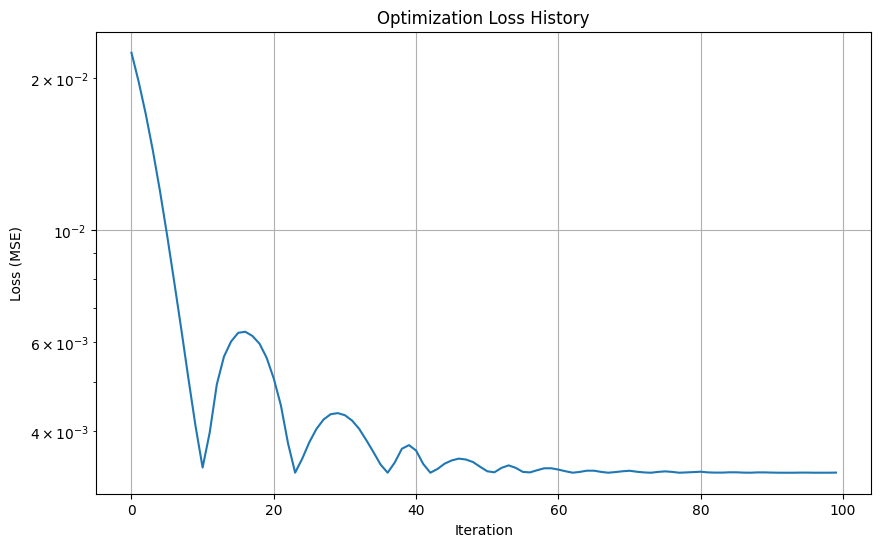

NameError: name 'true_temp_diff' is not defined

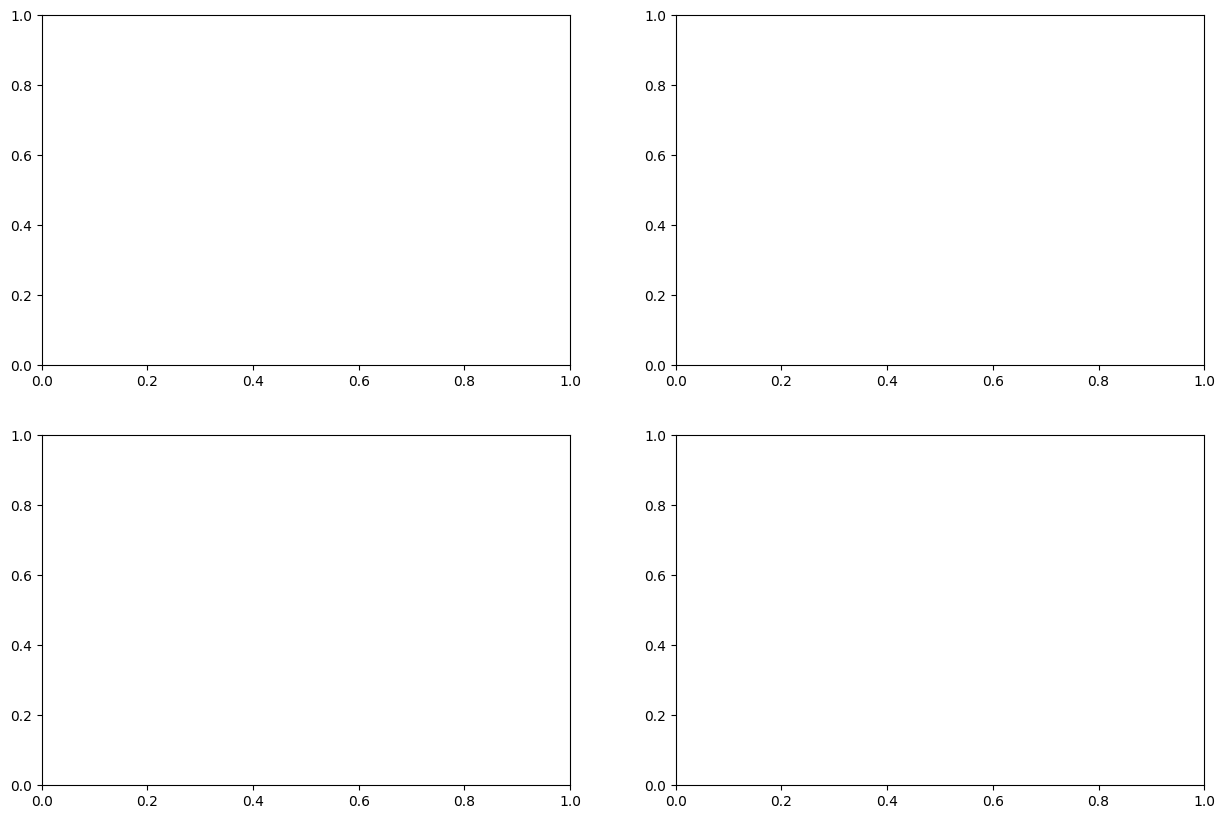

In [16]:
# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('Optimization Loss History')
plt.yscale('log')
plt.grid(True)
plt.show()

# Convert parameter history to a more convenient format
param_history = np.array(parameter_history)

# Plot the parameter convergence
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

param_names = ['Spot Theta (degrees)', 'Spot Phi (degrees)', 
               'Spot Radius (degrees)', 'Temperature Difference (K)']
true_values = [true_spot_theta, true_spot_phi, true_spot_radius, true_temp_diff]

for i in range(4):
    axs[i].plot(param_history[:, i], label='Optimized')
    axs[i].axhline(y=true_values[i], color='r', linestyle='--', label='True value')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(param_names[i])
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

# Create the final model with optimized parameters and compare to true model
final_surface = create_spotted_surface(final_params)
final_model_fluxes = compute_model_light_curve(final_params)

# Plot the final light curve comparison
plt.figure(figsize=(12, 7))
plt.plot(rotation_phases, observed_fluxes_with_noise, 'o', label='Observed data')
plt.plot(rotation_phases, final_model_fluxes, '-', label='Optimized model')
plt.plot(rotation_phases, observed_fluxes, '--', label='True model (no noise)')
plt.xlabel('Rotation phase (degrees)')
plt.ylabel('Normalized flux')
plt.title('Comparison of observed data and optimized model')
plt.legend()
plt.grid(True)
plt.show()

## 6. Examining the gradients

Let's take a closer look at how the gradients with respect to each parameter behave during optimization.

In [ ]:
# Define a grid of parameter values to explore
theta_range = jnp.linspace(40, 80, 20)
phi_range = jnp.linspace(80, 140, 20)

# Create a meshgrid for visualization
theta_grid, phi_grid = jnp.meshgrid(theta_range, phi_range)

# Function to compute loss at each point in the grid
def compute_loss_surface():
    loss_surface = jnp.zeros_like(theta_grid)
    
    for i in range(len(phi_range)):
        for j in range(len(theta_range)):
            # Use the final optimized values for radius and temp_diff
            test_params = jnp.array([theta_grid[i, j], phi_grid[i, j], final_params[2], final_params[3]])
            loss_surface = loss_surface.at[i, j].set(loss_fn(test_params))
    
    return loss_surface

# Compute the loss surface
loss_surface = compute_loss_surface()

# Create a 3D visualization of the loss landscape
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(theta_grid, phi_grid, loss_surface, cmap='viridis', alpha=0.8)

# Mark the true and optimized positions
ax.scatter([true_spot_theta], [true_spot_phi], [loss_fn(jnp.array([true_spot_theta, true_spot_phi, final_params[2], final_params[3]]))], 
           color='red', s=100, label='True parameters')
ax.scatter([final_params[0]], [final_params[1]], [loss_fn(final_params)], 
           color='green', s=100, label='Optimized parameters')

# Add labels and colorbar
ax.set_xlabel('Spot Theta (degrees)')
ax.set_ylabel('Spot Phi (degrees)')
ax.set_zlabel('Loss (MSE)')
ax.set_title('Loss landscape with respect to spot position')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.legend()

plt.show()

# Function to compute gradients at specific parameter values
def compute_gradient_field():
    grad_theta = jnp.zeros_like(theta_grid)
    grad_phi = jnp.zeros_like(phi_grid)
    
    for i in range(len(phi_range)):
        for j in range(len(theta_range)):
            test_params = jnp.array([theta_grid[i, j], phi_grid[i, j], final_params[2], final_params[3]])
            _, grads = loss_and_grad_fn(test_params)
            grad_theta = grad_theta.at[i, j].set(grads[0])
            grad_phi = grad_phi.at[i, j].set(grads[1])
    
    return grad_theta, grad_phi

# Compute gradient fields
grad_theta, grad_phi = compute_gradient_field()

# Visualize the gradient fields as a vector field
plt.figure(figsize=(12, 10))

# Normalize gradients for better visualization
gradients_magnitude = jnp.sqrt(grad_theta**2 + grad_phi**2)
max_magnitude = jnp.max(gradients_magnitude)
normalized_grad_theta = grad_theta / max_magnitude
normalized_grad_phi = grad_phi / max_magnitude

# Plot contours of the loss function
contour = plt.contourf(theta_grid, phi_grid, loss_surface, cmap='viridis', alpha=0.7, levels=20)
plt.colorbar(label='Loss (MSE)')

# Plot the gradient vector field
quiver = plt.quiver(theta_grid, phi_grid, -normalized_grad_theta, -normalized_grad_phi, 
                    gradients_magnitude, cmap='autumn', width=0.002)
plt.colorbar(quiver, label='Gradient magnitude')

# Mark the true and optimized positions
plt.scatter([true_spot_theta], [true_spot_phi], color='red', s=150, label='True parameters')
plt.scatter([final_params[0]], [final_params[1]], color='green', s=150, label='Optimized parameters')

# Plot the optimization trajectory
plt.plot(param_history[:, 0], param_history[:, 1], 'k--', alpha=0.6, label='Optimization path')

plt.xlabel('Spot Theta (degrees)')
plt.ylabel('Spot Phi (degrees)')
plt.title('Loss landscape and gradient field for spot position parameters')
plt.legend()
plt.grid(True)
plt.show()

## 7. Comparing the final surface maps

Let's visualize and compare the true and inferred surface temperature maps.

In [ ]:
def plot_surface_map(mesh, title):
    # Extract the coordinates and temperature
    x = mesh.centers[:, 0]
    y = mesh.centers[:, 1]
    z = mesh.centers[:, 2]
    temps = mesh.parameters[:, 0]
    
    # Create a figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface using a scatter plot with temperature color mapping
    scatter = ax.scatter(x, y, z, c=temps, cmap='plasma', s=50, alpha=0.8)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Temperature (K)')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    return fig, ax

# Plot the true surface map
plot_surface_map(true_surface, 'True Surface Temperature Map')
plt.show()

# Plot the inferred surface map
plot_surface_map(final_surface, 'Inferred Surface Temperature Map')
plt.show()

# Plot temperature difference
diff_mesh = final_surface._replace(parameters=final_surface.parameters - true_surface.parameters)
plot_surface_map(diff_mesh, 'Temperature Difference (Inferred - True)')
plt.show()

## 8. Conclusions

This notebook demonstrates how to use JAX's automatic differentiation to compute gradients with respect to spot parameters and perform parameter inference.

Key points:

1. JAX enables efficient computation of gradients with respect to stellar spot parameters
2. These gradients can be used for optimization and inference tasks
3. The optimization landscape can be complex, requiring careful consideration of initial conditions
4. Both the position (theta, phi) and the properties (radius, temperature) of spots can be inferred

In a real-world scenario, this approach could be extended to:
- Multiple spots with varying parameters
- More complex spot shapes and models
- Richer observational datasets (multi-wavelength photometry or spectroscopy)
- Bayesian inference to estimate parameter uncertainties